# Tải dữ liệu cuộc thi trực tiếp từ Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"quanghm25","key":"82356e7daab16e37fd4bc0c327f021d8"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

##Tải dữ liệu cuộc thi

In [ ]:
! kaggle competitions download -c tgs-salt-identification-challenge

 70% 29.0M/41.4M [00:00<00:00, 37.7MB/s]
100% 41.4M/41.4M [00:00<00:00, 76.8MB/s]
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 106MB/s]
 71% 27.0M/37.9M [00:00<00:00, 34.9MB/s]
100% 37.9M/37.9M [00:00<00:00, 64.6MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 125MB/s]
 92% 151M/163M [00:01<00:00, 147MB/s]
100% 163M/163M [00:01<00:00, 145MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 86.5MB/s]
100% 216M/217M [00:01<00:00, 125MB/s]
100% 217M/217M [00:01<00:00, 118MB/s]


##Giải nén các file zip

In [ ]:
! unzip "train.zip" -d "train"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/images/d80ead8703.png  
  inflating: train/images/b012e9ebb0.png  
  inflating: train/images/d3034e7a60.png  
  inflating: train/images/ae2ef70d51.png  
  inflating: train/images/1af44a9db0.png  
  inflating: train/images/41cfd4b320.png  
  inflating: train/images/853e89d0d3.png  
  inflating: train/images/2a484baa26.png  
  inflating: train/images/92e617896e.png  
  inflating: train/images/b70f0ab0c2.png  
  inflating: train/images/e8757626a1.png  
  inflating: train/images/6a3d92ce59.png  
  inflating: train/images/127ef4105f.png  
  inflating: train/images/d21012f5c1.png  
  inflating: train/images/1cb9549d2c.png  
  inflating: train/images/e030bdae65.png  
  inflating: train/images/0cf7155eb6.png  
  inflating: train/images/badb3ea766.png  
  inflating: train/images/9bd58061d6.png  
  inflating: train/images/2b1e71c2a3.png  
  inflating: train/images/28d42de29f.png  
  inflating: train/images/10833853b3.png

In [ ]:
! unzip "test.zip" -d "test"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: test/images/a3df74dd31.png  
  inflating: test/images/187ecc32d5.png  
  inflating: test/images/54538419f5.png  
  inflating: test/images/93614d4b95.png  
  inflating: test/images/50a91adce8.png  
  inflating: test/images/97d23cea10.png  
  inflating: test/images/ca04c19c0b.png  
  inflating: test/images/d168218bac.png  
  inflating: test/images/a670e833a4.png  
  inflating: test/images/a964a0f499.png  
  inflating: test/images/371bf59030.png  
  inflating: test/images/fc74f77bae.png  
  inflating: test/images/f63dc1e3be.png  
  inflating: test/images/b807539a5f.png  
  inflating: test/images/1dfcbf4bca.png  
  inflating: test/images/a971d2ae53.png  
  inflating: test/images/4ad823e2d3.png  
  inflating: test/images/85a9687a4f.png  
  inflating: test/images/da5b430ecd.png  
  inflating: test/images/b1a2903d1c.png  
  inflating: test/images/70958cacd4.png  
  inflating: test/images/2093e5c98e.png  
  inflating: test/i

#Import các thư viện

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import  Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, concatenate, Dropout, BatchNormalization, Activation, Input, Add
    
from keras import models, layers, callbacks, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import load_img, img_to_array

# Xử lý dữ liệu

Đầu tiên, em lưu đường dẫn tới thư mục gốc (../content/) vào trong biến ROOT_PATH, các thư mục, tệp dữ liệu được tải xuống từ Kaggle đều ở trong thư mục này

In [ ]:
ROOT_PATH = "../content/"

##Đọc dữ liệu
Dữ liệu của cuộc thi bao gồm:
File “train.csv”: 
- Cột “id”: ID - tên của ảnh
- Cột “rle_mask”: mã hóa loạt dài được mã hóa từ mask của ảnh. Các mask sẽ được làm phẳng theo thứ tự từ trên xuống dưới, từ trái qua phải. Sau đó sẽ được mã hóa run-length theo vị trí pixel có giá trị bằng $1$ và số pixel có giá trị bằng $1$ kể từ nó. 
File “depths.csv”: Tên (ID) của ảnh và độ sâu của pixel chính giữa ảnh

File “sample_submission.csv”: Tên (ID) của ảnh và rle_mask cần dự đoán của ảnh đó

File “train.zip” → Giải nén thành folder “train”: 

- Folder “images” chứa 4000 ảnh huấn luyện
- Folder “masks” chứa 4000 ảnh mask tương ứng

File “test.zip” → Giải nén thành folder “test”: chứa 18000 ảnh địa chấn cần dự đoán mask.

In [ ]:
train_df = pd.read_csv(ROOT_PATH + "train.csv")
test_df = pd.read_csv(ROOT_PATH + "sample_submission.csv")
depths_df = pd.read_csv(ROOT_PATH + "depths.csv")

train_df.head()

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4000 non-null   object
 1   rle_mask  2438 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


## Tính độ phủ của muối trong ảnh

In [ ]:
def get_coverage(rle_mask):
    
    if pd.isna(rle_mask): # rle_mask NaN --> không có muối
        return 0
    else:   
        arr = rle_mask.split() # cắt chuỗi rle thành list   
        coverage = sum(int(x) for x in arr[1::2]) / (101**2) #Tổng số pixel là muối: Trong chuỗi rle, phần tử thứ x%2==0 là vị trí pixel, phần tử x+1 là số pixel chứa muối tính từ pixel x
        return np.round(coverage,1)

train_df['coverage'] = train_df['rle_mask'].map(get_coverage)
train_df.head()

,id,rle_mask,coverage
0,575d24d81d,NaN,0.0
1,a266a2a9df,5051 5151,0.5
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,1.0
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,0.1
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,0.0


## Thêm trường dữ liệu 'images' vào bảng
Đọc ảnh từ file và chuẩn hóa về [0, 1]

In [ ]:
train_df["images"] = [img_to_array(load_img(ROOT_PATH + "train/images/" + id +".png", color_mode="grayscale"), dtype=np.uint8) / 255 for id in tqdm(train_df['id'])]
train_df.head()

  0%|          | 0/4000 [00:00<?, ?it/s]

,id,rle_mask,coverage,images
0,575d24d81d,NaN,0.0,"[[[0.5254901960784314], [0.5137254901960784], ..."
1,a266a2a9df,5051 5151,0.5,"[[[0.3411764705882353], [0.3764705882352941], ..."
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,1.0,"[[[0.5686274509803921], [0.4666666666666667], ..."
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,0.1,"[[[0.5411764705882353], [0.4745098039215686], ..."
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,0.0,"[[[0.06666666666666667], [0.0784313725490196],..."


## Thêm trường dữ liệu 'images' vào bảng
Đọc ảnh từ file và chuẩn hóa về [0, 1]

In [ ]:
train_df["masks"] = [img_to_array(load_img(ROOT_PATH + "train/masks/" + id +".png", color_mode="grayscale"), dtype=np.uint8) / 255 for id in tqdm(train_df['id'])]
train_df.head()

  0%|          | 0/4000 [00:00<?, ?it/s]

,id,rle_mask,coverage,images,masks
0,575d24d81d,NaN,0.0,"[[[0.5254901960784314], [0.5137254901960784], ...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,a266a2a9df,5051 5151,0.5,"[[[0.3411764705882353], [0.3764705882352941], ...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,1.0,"[[[0.5686274509803921], [0.4666666666666667], ...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,0.1,"[[[0.5411764705882353], [0.4745098039215686], ...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,0.0,"[[[0.06666666666666667], [0.0784313725490196],...","[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


## Biểu thị dữ liệu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: No contour levels were found within the data range.


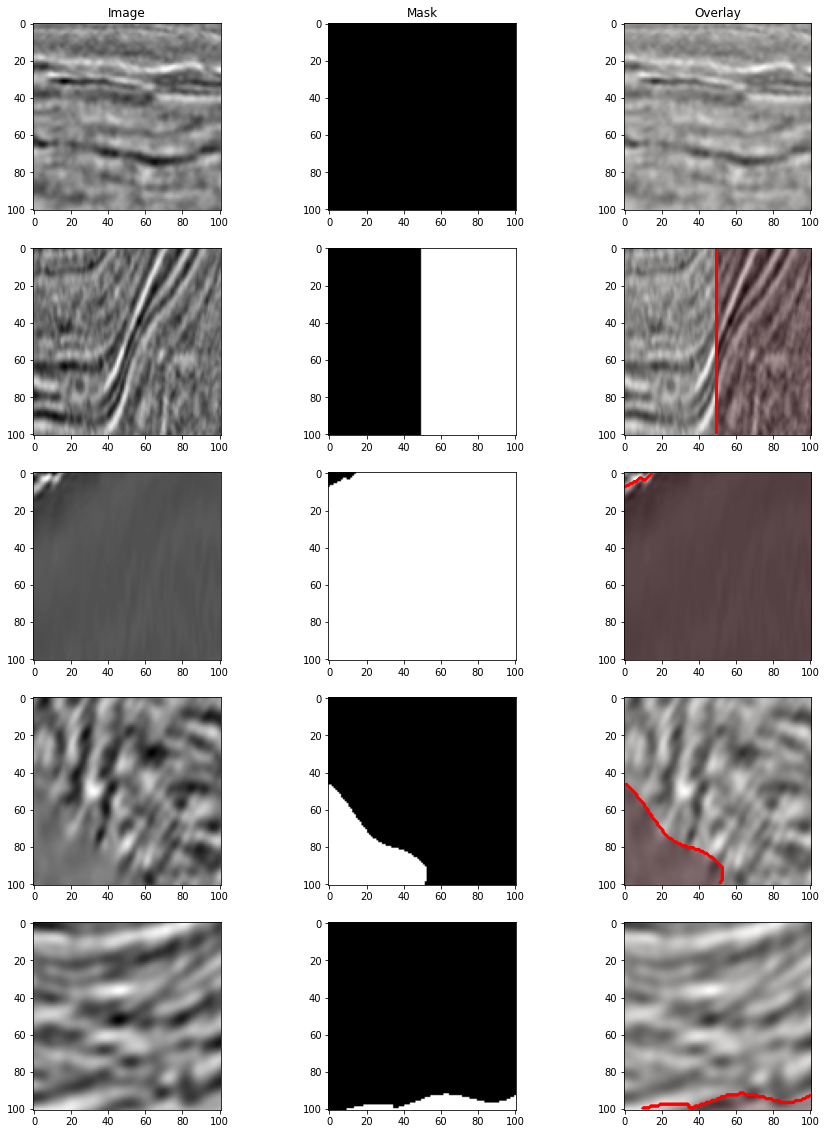

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20));
axes[0][0].set_title('Image', size='large')
axes[0][1].set_title('Mask', size='large')
axes[0][2].set_title('Overlay', size='large')
for row in range(5):
    # Image
    axes[row][0].imshow(train_df['images'][row],cmap="gray")

    # Mask
    axes[row][1].imshow(train_df['masks'][row],cmap="gray")

    # Overlay
    axes[row][2].imshow(train_df['images'][row],cmap="gray")
    axes[row][2].imshow(train_df['masks'][row], alpha=0.2, cmap="Reds")
    axes[row][2].contour(train_df['masks'][row].squeeze(), colors='red')

Đọc mask từ file và chuẩn hóa về [0, 1]

Đếm và biểu diễn số lượng ảnh tại mỗi mức bao phủ muối

In [ ]:
train_df.value_counts('coverage',sort=False, ascending=True)

coverage
0.0    1983
0.1     326
0.2     230
0.3     213
0.4     197
0.5     216
0.6     197
0.7     163
0.8     151
0.9     161
1.0     163
dtype: int64

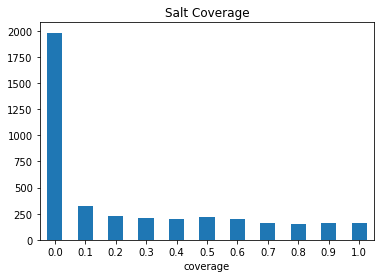

In [ ]:
train_df.value_counts('coverage', sort=False, ascending=True).plot(kind ='bar', title='Salt Coverage' , rot=0);

## Chia tập dữ liệu huấn luyện, kiểm thử

Chia tập train/ valid theo độ bao phủ muối với tỉ lệ 8/2

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split( np.array(train_df.images.tolist()).reshape(-1, 101, 101, 1), 
                                                      np.array(train_df.masks.tolist()).reshape(-1, 101, 101, 1),
                                                      test_size = 0.2, 
                                                      stratify=train_df.coverage, 
                                                      random_state=1234)

In [ ]:
print(x_train.shape)

(3200, 101, 101, 1)


## Lật ảnh

Lật ảnh theo chiều ngang (trái <-> phải) để tăng lượng dữ liệu.

In [ ]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [ ]:
print(x_train.shape)

(6400, 101, 101, 1)


# Xây dựng mô hình

## Metric của cuộc thi

Metric được sử dụng cho cuộc thi này là mean average precision (MAP) tại các ngưỡng intersection over union (IoU) khác nhau.

In [ ]:
def iou_vector(trues, preds):
    SMOOTH = 1e-10
    batch_size = trues.shape[0]
    
    metric = []

    for idx in range(batch_size):

        true, pred = trues[idx], preds[idx]

        # Tính Intersection của mask được cho và mask dự đoán
        intersection = np.logical_and(true, pred)

        # Tính Union của mask được cho và mask dự đoán
        union = np.logical_or(true,pred)
        
        iou = (np.sum(intersection) + SMOOTH) / (np.sum(union) + SMOOTH)
        
        # So sánh iou với các ngưỡng 
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
            
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    
    return tf.py_function(iou_vector, [label, pred>0.5], tf.float64)

## Khối Conv và Res

Khối tích chập và khối phần dư được xây dựng dựa trên: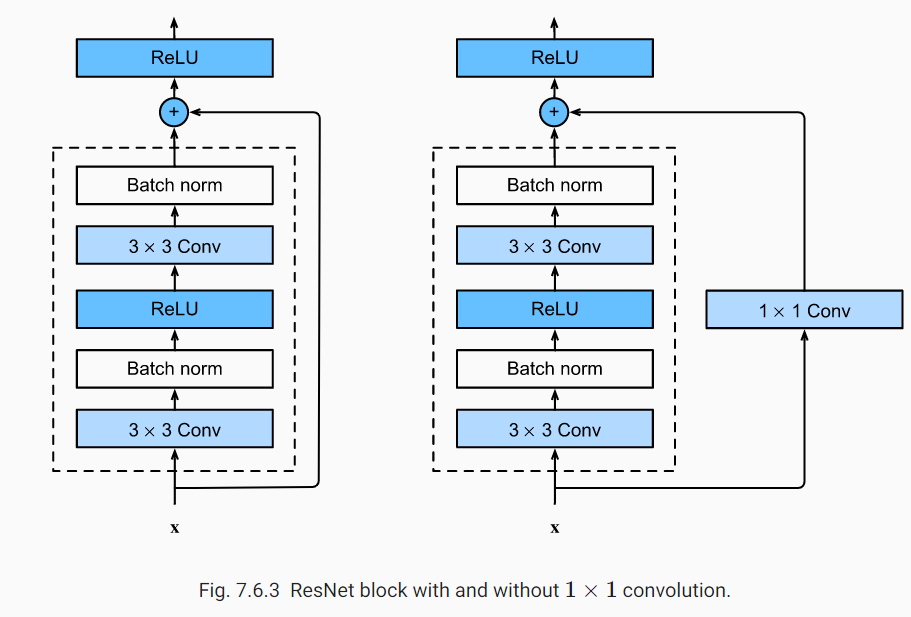

In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

In [ ]:
def residual_block(blockInput, num_filters=16):
    x = convolution_block(blockInput, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    x = Activation('relu')(x)
    return x

## Unet

In [ ]:
def build_model(input_layer):
    start_filters = 16
    # 101 -> 50
    conv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_filters * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_filters * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_filters * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_filters * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_filters * 16, (3, 3), activation="relu", padding="same")(convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_filters * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_filters * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)  #Vì 12*2=24 < 25 nên dùng padding valid
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

##Unet với khối phần dư

Mô hình U-Net kết hợp khối residual được xây dựng dựa trên hình ảnh bên dưới.
Các lớp Conv2D đều dùng padding="same" để giữ nguyên kích thước của feature map ở mỗi tầng ở cả bên phần bên trái và phần bên phải.
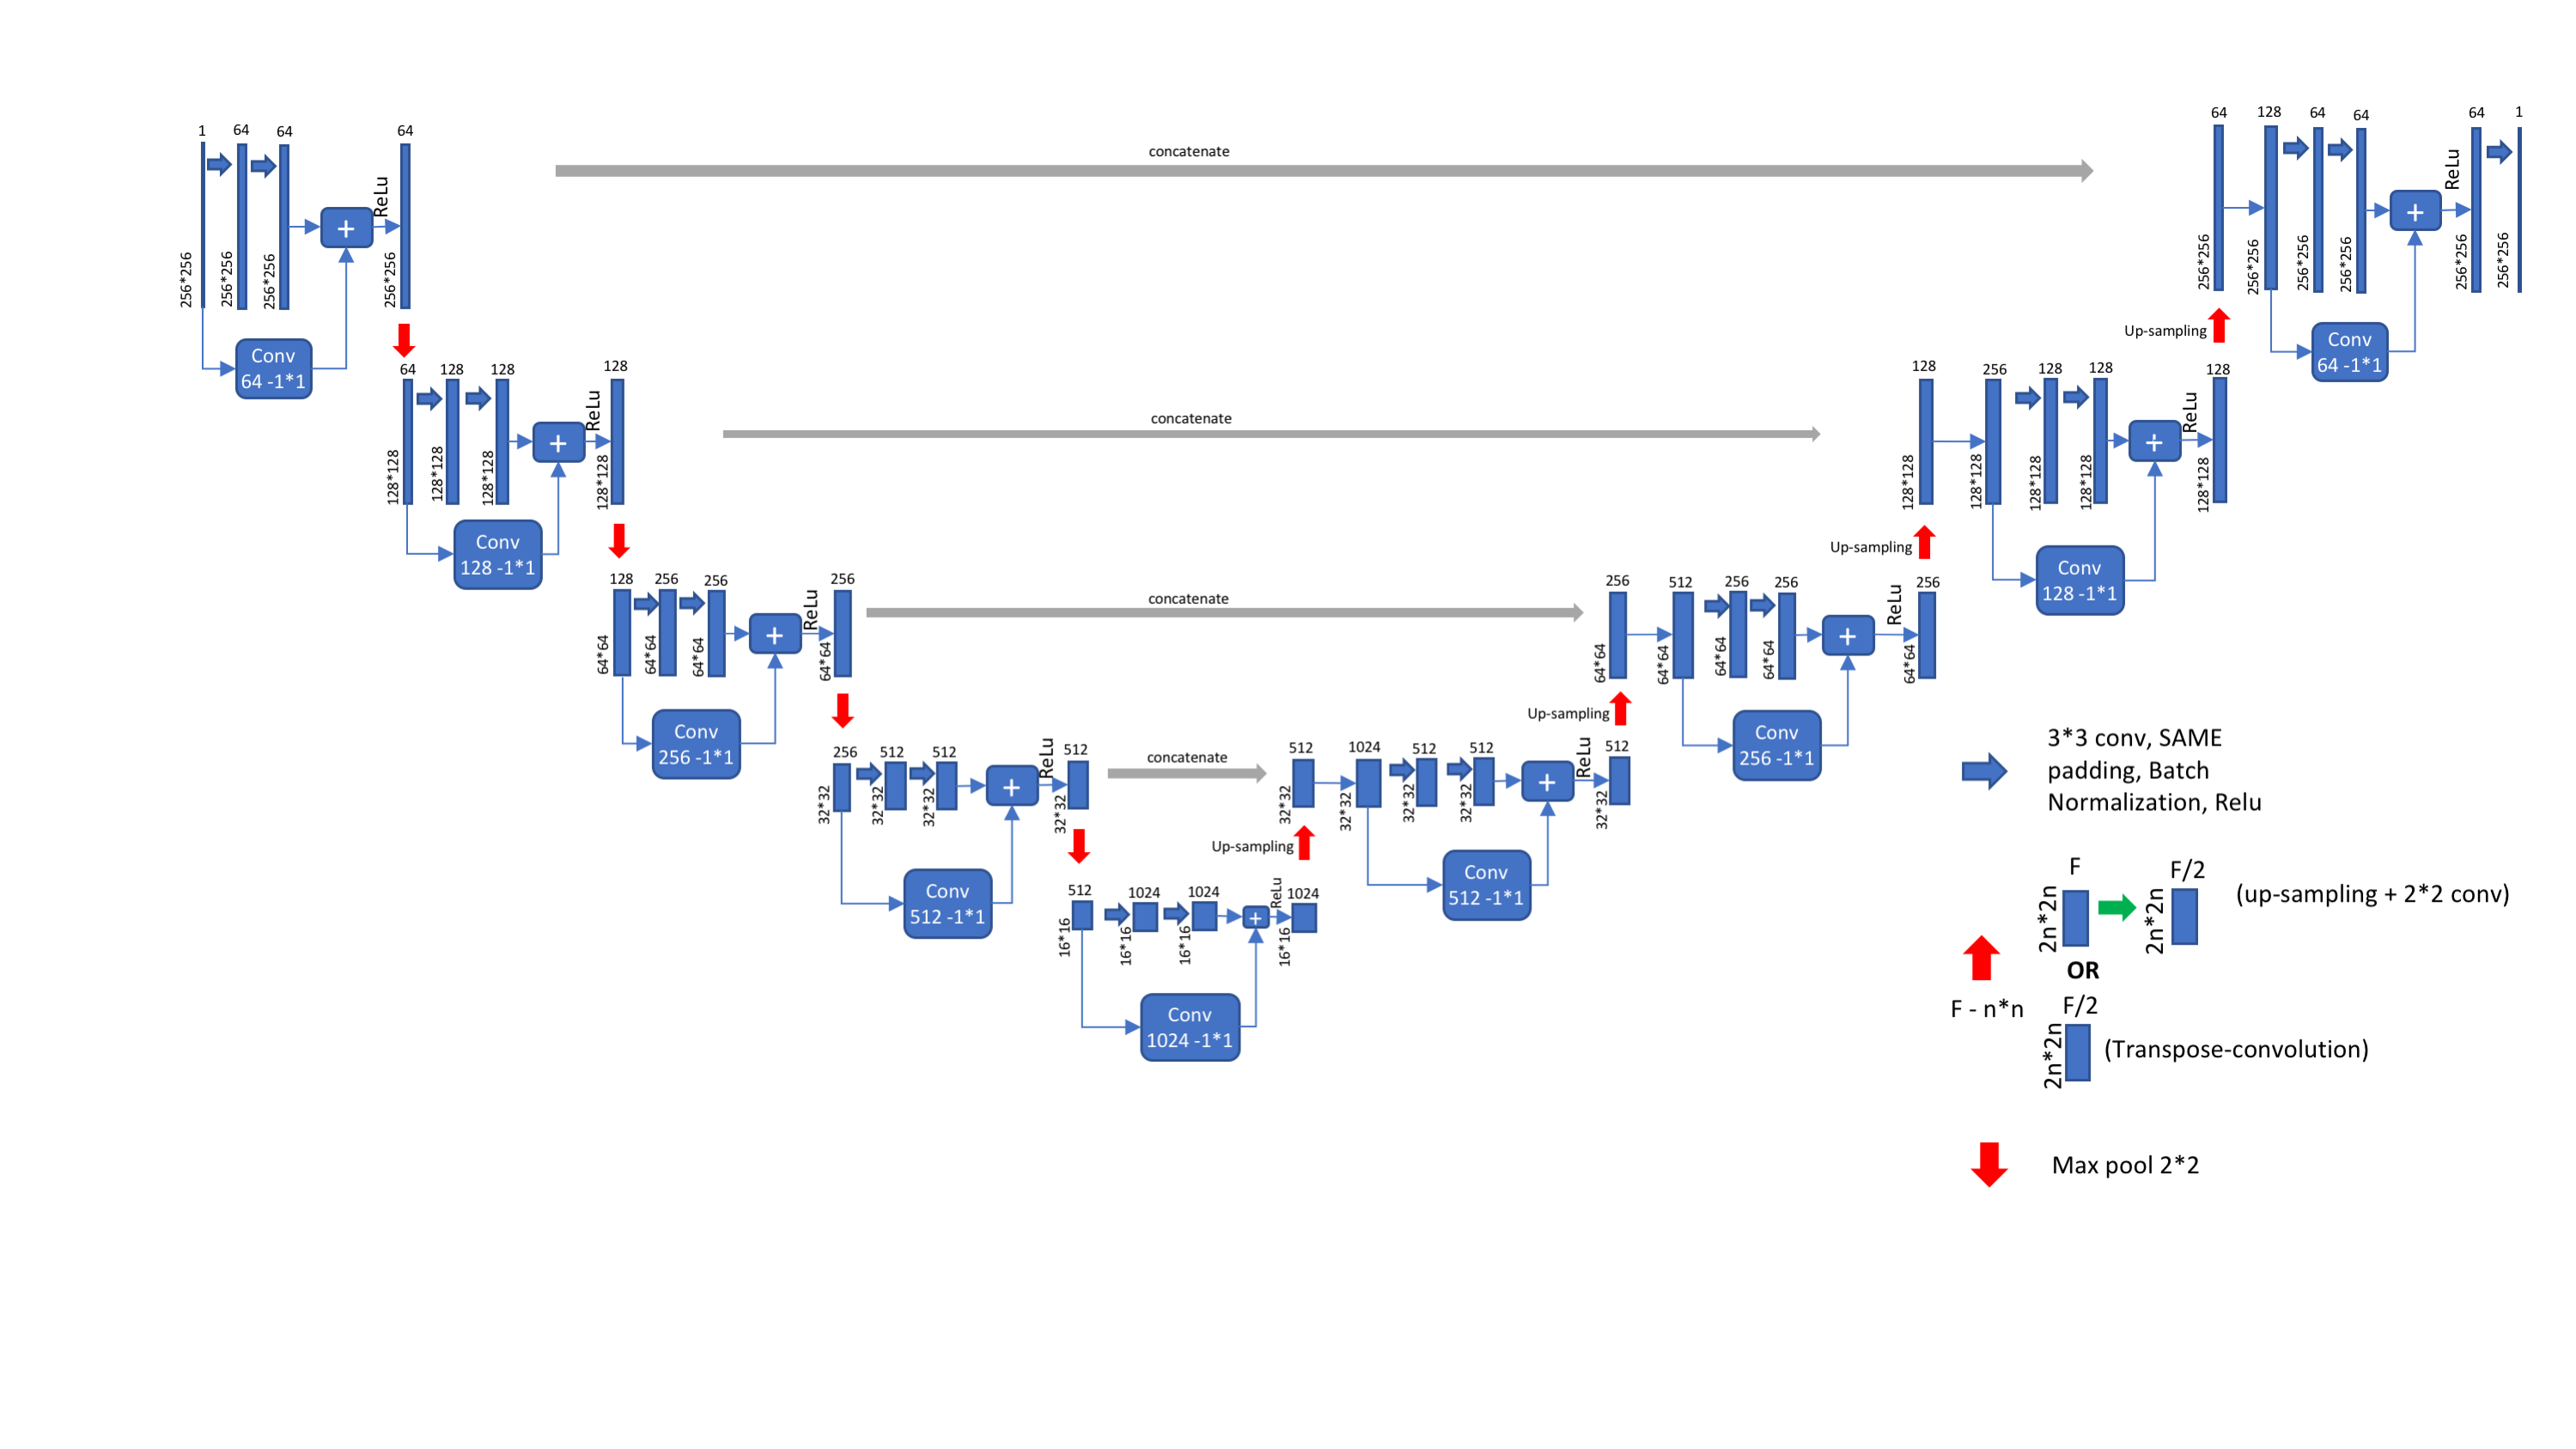

In [ ]:
def build_model(input_layer):
    start_filters = 16
    DropoutRatio = 0.5

    # Encoder - Layer 1: 101 -> 50
    conv1 = Conv2D(start_filters * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_filters * 1)
    conv1 = residual_block(conv1,start_filters * 1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # Encoder - Layer 2: 50 -> 25
    conv2 = Conv2D(start_filters * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_filters * 2)
    conv2 = residual_block(conv2,start_filters * 2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # Encoder - Layer 3: 25 -> 12
    conv3 = Conv2D(start_filters * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_filters * 4)
    conv3 = residual_block(conv3,start_filters * 4)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # Encoder - Layer 4: 12 -> 6
    conv4 = Conv2D(start_filters * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_filters * 8)
    conv4 = residual_block(conv4,start_filters * 8)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Bottom
    convb = Conv2D(start_filters * 16, (3, 3), activation=None, padding="same")(pool4)
    convb = residual_block(convb,start_filters * 16)
    convb = residual_block(convb,start_filters * 16)
    
    # Decoder- Layer 4: 6 -> 12
    deconv4 = Conv2DTranspose(start_filters * 8, (3, 3), strides=(2, 2), padding="same")(convb)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_filters * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_filters * 8)
    uconv4 = residual_block(uconv4,start_filters * 8)
    
    # Decoder - Layer 3: 12 -> 25
    deconv3 = Conv2DTranspose(start_filters * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4) # 12*2<25 --> 'valid' mode 
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_filters * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_filters * 4)
    uconv3 = residual_block(uconv3,start_filters * 4)

    # Decoder - Layer 2: 25 -> 50
    deconv2 = Conv2DTranspose(start_filters * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_filters * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_filters * 2)
    uconv2 = residual_block(uconv2,start_filters * 2)
    
    # Decoder - Layer 1: 50 -> 101
    deconv1 = Conv2DTranspose(start_filters * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2) # 50*2<101 --> 'valid' mode
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_filters * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_filters * 1)
    uconv1 = residual_block(uconv1,start_filters * 1)
    
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)

    return output_layer


## Dịch mô hình

Đầu vào của mô hình là ảnh 101x101x1
Vì đây là bài toán phân loại pixel từng ảnh là muối hay không nên hàm loss được dùng là "binary cross entropy". Hàm tối ưu là hàm Adam

In [ ]:
input_layer = Input((101,101,1))
output_layer = build_model(input_layer)
model = Model(input_layer, output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= [my_iou_metric])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 101, 101, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 101, 101, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 101, 101, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

## Huấn luyện mô hình

Mô hình được huấn luyện trên tập train/ valid đã chia.
Dùng Callback API:
- EarlyStopping để dừng sớm việc huấn luyện sau khi điểm metric không tăng.
- ReduceLROnPlateau dùng để giảm tốc độc học (learning rate) sau 1 vài epoch mà điểm metric không tăng.

In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./best.model", monitor='val_my_iou_metric', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 100
bacth_size = 32
history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid), 
                    epochs=epochs,
                    batch_size=bacth_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.3783 - my_iou_metric: 0.2460
Epoch 00001: val_my_iou_metric improved from inf to 0.13388, saving model to ./best.model
INFO:tensorflow:Assets written to: ./best.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


200/200 [==============================] - 117s 511ms/step - loss: 0.3783 - my_iou_metric: 0.2460 - val_loss: 3.0271 - val_my_iou_metric: 0.1339 - lr: 0.0010
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.2786 - my_iou_metric: 0.4979
Epoch 00002: val_my_iou_metric did not improve from 0.13388
200/200 [==============================] - 75s 373ms/step - loss: 0.2786 - my_iou_metric: 0.4979 - val_loss: 0.8100 - val_my_iou_metric: 0.3564 - lr: 0.0010
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2556 - my_iou_metric: 0.5291
Epoch 00003: val_my_iou_metric did not improve from 0.13388
200/200 [==============================] - 75s 375ms/step - loss: 0.2556 - my_iou_metric: 0.5291 - val_loss: 0.4065 - val_my_iou_metric: 0.3246 - lr: 0.0010
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.2323 - my_iou_metric: 0.5597
Epoch 00004: val_my_iou_metric did not improve from 0.13388
200/200 [==============================] -

## Biểu diễn giá trị hàm loss và điểm metric

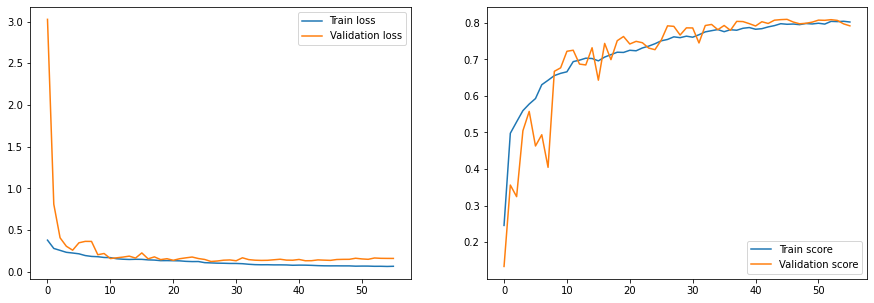

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

Sử dụng mô hình để dự đoán

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


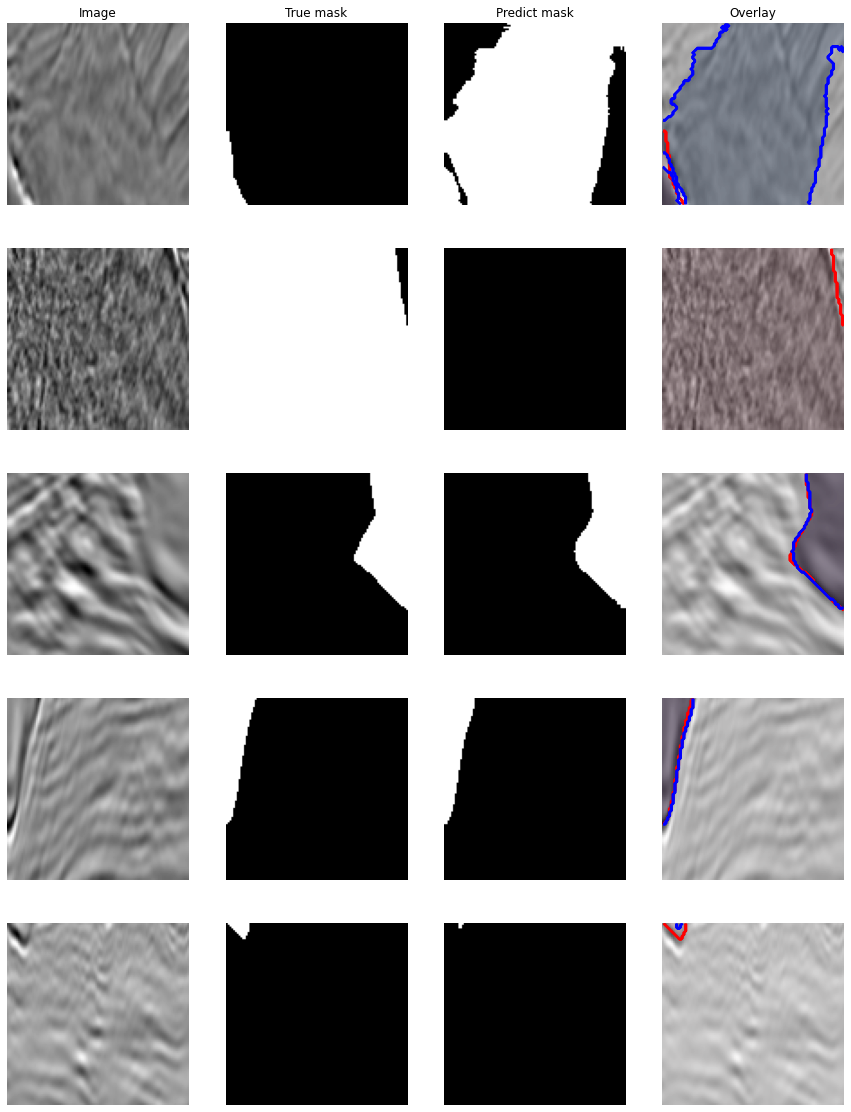

In [ ]:
pred_valid = model.predict(x_valid)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 20));
axes[0][0].set_title('Image', size='large')
axes[0][1].set_title('True mask', size='large')
axes[0][2].set_title('Predict mask', size='large')
axes[0][3].set_title('Overlay', size='large')
for row in range(5):
    # Image
    axes[row][0].axis('off')
    axes[row][0].imshow(x_valid[row].reshape(101,101),cmap="gray")

    # True mask
    axes[row][1].axis('off')
    axes[row][1].imshow(y_valid[row].reshape(101,101),cmap="gray")

    # Predict mask
    axes[row][2].axis('off')
    axes[row][2].imshow(np.round(pred_valid[row].reshape(101,101)),cmap="gray")

    # Overlay
    axes[row][3].axis('off')
    axes[row][3].imshow(x_valid[row].reshape(101,101),cmap="gray")
    axes[row][3].imshow(y_valid[row].reshape(101,101), alpha=0.2, cmap="Reds")
    axes[row][3].contour(y_valid[row].reshape(101,101).squeeze(), colors='red')
    axes[row][3].imshow(np.round(pred_valid[row].reshape(101,101)), alpha=0.2, cmap="Blues")
    axes[row][3].contour(np.round(pred_valid[row].reshape(101,101)).squeeze(), colors='blue')

Em thử dùng mô hình để dự đoán ảnh trong tập valid. Tiếp theo, em dùng mô hình dự đoán ảnh trong tập valid bị lật, sau đó lật lại mask, cộng với mask đã dự đoán bên trên rồi chia 2 lấy trung bình. Tuy nhiên kết quả có vẻ cũng không khác mấy.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: No contour levels were found within the data range.


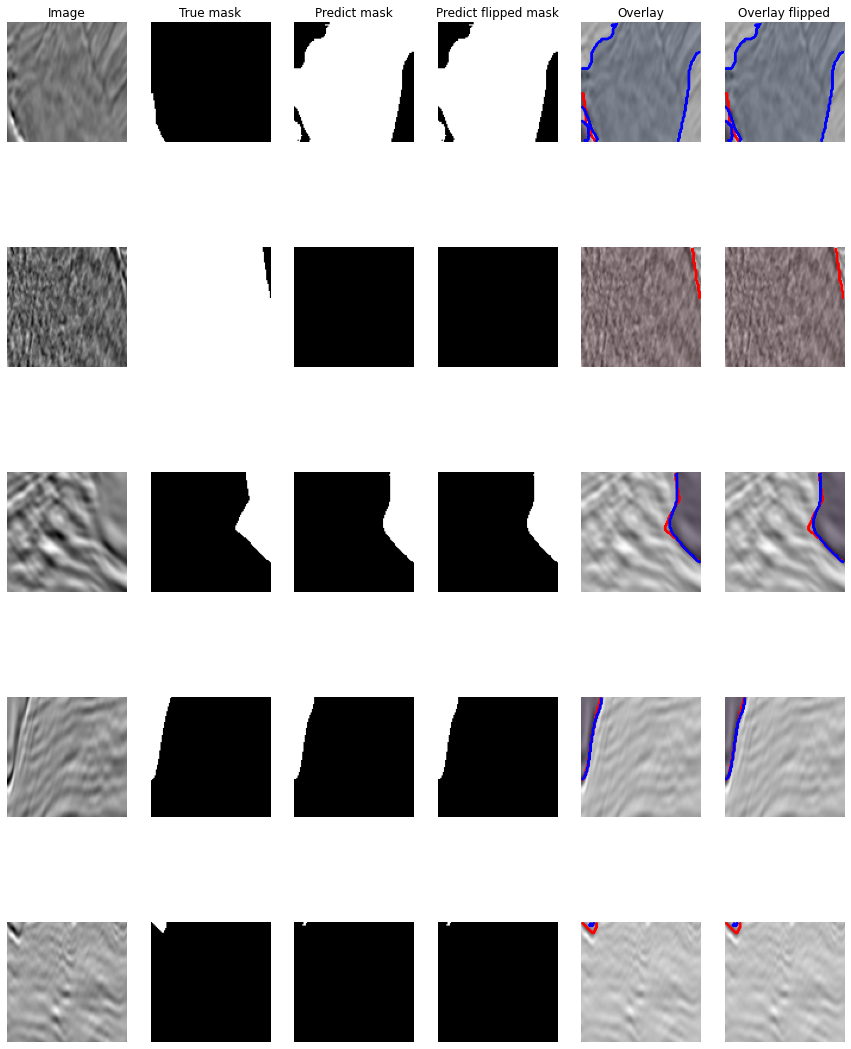

In [ ]:
pred_valid = model.predict(x_valid)

pred_valid_flipped = pred_valid
x_valid_fliplr = np.array([np.fliplr(x) for x in x_valid])
pred_valid_fliplr = model.predict(x_valid_fliplr)
pred_valid_flipped += np.array([ np.fliplr(x) for x in pred_valid_fliplr])
pred_valid_flipped /= 2


fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(15, 20));
axes[0][0].set_title('Image', size='large')
axes[0][1].set_title('True mask', size='large')
axes[0][2].set_title('Predict mask', size='large')
axes[0][3].set_title('Predict flipped mask', size='large')
axes[0][4].set_title('Overlay', size='large')
axes[0][5].set_title('Overlay flipped', size='large')
for row in range(5):
    # Image
    axes[row][0].axis('off')
    axes[row][0].imshow(x_valid[row].reshape(101,101),cmap="gray")

    # True mask
    axes[row][1].axis('off')
    axes[row][1].imshow(y_valid[row].reshape(101,101),cmap="gray")

    # Predict mask
    axes[row][2].axis('off')
    axes[row][2].imshow(np.round(pred_valid[row].reshape(101,101)),cmap="gray")

    # Predict flipped mask
    axes[row][3].axis('off')
    axes[row][3].imshow(np.round(pred_valid_flipped[row].reshape(101,101)),cmap="gray")

    # Overlay
    axes[row][4].axis('off')
    axes[row][4].imshow(x_valid[row].reshape(101,101),cmap="gray")
    axes[row][4].imshow(y_valid[row].reshape(101,101), alpha=0.2, cmap="Reds")
    axes[row][4].contour(y_valid[row].reshape(101,101).squeeze(), colors='red')
    axes[row][4].imshow(np.round(pred_valid[row].reshape(101,101)), alpha=0.2, cmap="Blues")
    axes[row][4].contour(np.round(pred_valid[row].reshape(101,101)).squeeze(), colors='blue')

    # Overlay flipped
    axes[row][5].axis('off')
    axes[row][5].imshow(x_valid[row].reshape(101,101),cmap="gray")
    axes[row][5].imshow(y_valid[row].reshape(101,101), alpha=0.2, cmap="Reds")
    axes[row][5].contour(y_valid[row].reshape(101,101).squeeze(), colors='red')
    axes[row][5].imshow(np.round(pred_valid_flipped[row].reshape(101,101)), alpha=0.2, cmap="Blues")
    axes[row][5].contour(np.round(pred_valid_flipped[row].reshape(101,101)).squeeze(), colors='blue')

# Dự đoán mask của ảnh trong tập test

In [ ]:
# Load và chuẩn hóa ảnh
test_imgs = [load_img(ROOT_PATH + "test/images/" + image_name + '.png', color_mode='grayscale') for image_name in tqdm(test_df['id'])]
test_imgs = np.array([img_to_array(img, dtype=np.uint8)/255 for img in test_imgs])

# Dùng mô hình dự đoán mask
pred_test = model.predict(test_imgs, verbose=1)

  0%|          | 0/18000 [00:00<?, ?it/s]

563/563 [==============================] - 53s 95ms/step


In [ ]:
# Lật ảnh test và dự đoán mask
test_imgs_flip = np.array([np.fliplr(x) for x in test_imgs])
pred_test_flip = model.predict(test_imgs_flip, verbose=1)

# Lật lại mask rồi cộng với mask ảnh test rồi lấy trung bình
pred_test += np.array([ np.fliplr(x) for x in pred_test_flip])
pred_test/=2

563/563 [==============================] - 53s 94ms/step


## Mã hóa run-length từ mask dự đoán

In [ ]:
def mask2rle(mask):
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
rle_masks = [mask2rle(np.round(x)) for x in pred_test]

In [ ]:
test_df["rle_mask"] = rle_masks
test_df.to_csv("submission.csv", index=False)